In [1]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np

In [2]:
#HELPER FUNCTIONS
def get_data_s3():
    data_list = []
    data_dict = {}

    # Iterate through all buckets
    for bucket in s3.buckets.all():
        # Iterate through all items
        for obj in s3.Bucket(bucket.name).objects.all():
            if('data/' in obj.key and obj.key != 'data/'):
                data_list.append(obj.key)
                
                # Save STM files as DataFrames
                #if('STM' in obj.key and 'non' not in obj.key): 
                objct = s3.Bucket(bucket.name).Object(obj.key).get()
                data_dict[obj.key] = pd.read_csv(objct['Body'], index_col=0)

    print(data_list)
    
    return data_dict

def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return None
    else:
        return int(''.join(c for c in time if c.isdigit()))
    
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    return df

In [5]:
all_data = get_data_s3()

['data/CRM_STM.csv', 'data/CRM_lost.csv', 'data/CRM_nonSTM.csv', 'data/FTS_STM.csv', 'data/FTS_lost.csv', 'data/FTS_nonSTM.csv', 'data/MK_STM.csv', 'data/MK_lost.csv', 'data/MK_nonSTM.csv', 'data/SG_STM.csv', 'data/SG_lost.csv', 'data/SG_nonSTM.csv', 'data/YZ_STM.csv', 'data/YZ_lost.csv', 'data/YZ_nonSTM.csv']


In [6]:
all_data.keys()

dict_keys(['data/CRM_STM.csv', 'data/CRM_lost.csv', 'data/CRM_nonSTM.csv', 'data/FTS_STM.csv', 'data/FTS_lost.csv', 'data/FTS_nonSTM.csv', 'data/MK_STM.csv', 'data/MK_lost.csv', 'data/MK_nonSTM.csv', 'data/SG_STM.csv', 'data/SG_lost.csv', 'data/SG_nonSTM.csv', 'data/YZ_STM.csv', 'data/YZ_lost.csv', 'data/YZ_nonSTM.csv'])

In [7]:
for key in all_data.keys():
    print(key)
    print(all_data[key].describe(include='all'))
    print("=====================================================")

data/CRM_STM.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count              3149.000000                 3149                 3149
unique                     NaN                 2016                 3107
top                        NaN  2009-05-21 01:29:13  2009-05-21 01:29:13
freq                       NaN                  916                   25
mean                 12.091458                  NaN                  NaN
std                  10.898481                  NaN                  NaN
min                   1.000000                  NaN                  NaN
25%                   3.000000                  NaN                  NaN
50%                   8.000000                  NaN                  NaN
75%                  20.000000                  NaN                  NaN
max                  94.000000                  NaN                  NaN
data/CRM_lost.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count           

        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count         59689.000000                59689                59689
unique                 NaN                56621                56727
top                    NaN  2017-02-14 17:40:22  2020-08-18 19:41:43
freq                   NaN                   26                   14
mean             39.566537                  NaN                  NaN
std              96.149646                  NaN                  NaN
min               1.000000                  NaN                  NaN
25%               5.000000                  NaN                  NaN
50%              15.000000                  NaN                  NaN
75%              42.000000                  NaN                  NaN
max           11706.000000                  NaN                  NaN
data/MK_nonSTM.csv
        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count        598696.000000               598696               598696
unique         

In [19]:
#MERGE all DF for STM
STM = None
nonSTM = None
lost = None


for key in all_data.keys():
    df = all_data[key]
    how = 'outer'
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], values=['TotalSeatGeekTransactions', 'TotalTicketVolume', 'TotalScannedTicketVolume', 'TotalTicketDollarValue'], index=['SSB_CRMSYSTEM_CONTACT_ID'],
                    columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], aggfunc=np.sum)
        df = pd.DataFrame(pivoted.to_records())
        sg = pd.DataFrame()
        sg['SSB_CRMSYSTEM_CONTACT_ID'] = df['SSB_CRMSYSTEM_CONTACT_ID']
        sg['total_scanned'] = df["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        sg['primary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        sg['secondary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        sg['secondary_sell_transactions'] = df["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        sg['primary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        sg['secondary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + df["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        sg['secondary_sell_dollars'] = df["('TotalTicketDollarValue', 'Sell', 'Resale')"] + df["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        sg['primary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Primary')"]
        sg['secondary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Resale')"] + df["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        sg['secondary_sell_tickets'] = df["('TotalTicketVolume', 'Sell', 'Resale')"] + df["('TotalTicketVolume', 'Sell', 'Transfer')"]
        
        df = sg
        df = df.merge(all_data[key][['EarliestSeatGeekDate' ,'LatestSeatGeekDate']], on = 'SSB_CRMSYSTEM_CONTACT_ID')
        how = 'right'
        
    if('STM' in key and 'non' not in key): 
        if STM is None:
            STM = df
        else:
            STM = STM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('non' in key): 
        if nonSTM is None:
            nonSTM = df
        else:
            nonSTM = nonSTM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('lost' in key): 
        if lost is None:
            lost = df
        else:
            lost = lost.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
    else:
        pass

In [27]:
stm_null = pd.DataFrame(STM.isna().sum()/len(STM), columns = ['STM_Pct_Null'])
nonstm_null = pd.DataFrame(nonSTM.isna().sum()/len(nonSTM), columns = ['nonSTM_Pct_Null'])
lost_null = pd.DataFrame(lost.isna().sum()/len(lost), columns = ['lost_Pct_Null'])

all_null = stm_null.merge(nonstm_null.merge(lost_null, left_index=True, right_index=True), left_index=True, right_index=True)

In [21]:
STM = convert_time_int(STM)
nonSTM = convert_time_int(nonSTM)
lost = convert_time_int(lost)


In [11]:
print(f"STM Length: {len(STM)}")
print(f"nonSTM Length: {len(nonSTM)}")
print(f"lost Length: {len(lost)}")


STM Length: 2250
nonSTM Length: 133188
lost Length: 20669


In [28]:
all_null.sort_values(by = 'STM_Pct_Null', ascending = True)

,STM_Pct_Null,nonSTM_Pct_Null,lost_Pct_Null
SSB_CRMSYSTEM_CONTACT_ID,0.000000,0.000008,0.000000
LatestSeatGeek_int,0.008889,0.044171,0.027481
EarliestSeatGeek_int,0.008889,0.044171,0.027481
primary_purchase_transactions,0.080000,0.575390,0.534665
primary_purchase_dollars,0.080000,0.575390,0.534665
primary_purchase_tickets,0.080000,0.575390,0.534665
TotalCRMActivityVolume,0.103556,0.203840,0.041270
EarliestCRM,0.103556,0.203840,0.041270
LatestCRM,0.103556,0.203840,0.041270
EarliestCRM_int,0.103556,0.203840,0.041270


In [38]:
 
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

In [26]:
#PERCENT OF ROWS WITH MISSING VALUES
print(f"STM: {(STM.shape[0] - STM.dropna().shape[0])/len(STM)}")
print(f"nonSTM: {(nonSTM.shape[0] - nonSTM.dropna().shape[0])/len(nonSTM)}")
print(f"lost: {(lost.shape[0] - lost.dropna().shape[0])/len(lost)}")


STM: 0.23244444444444445
nonSTM: 0.675714028290837
lost: 0.5735158933668779


In [24]:
#DROP COLUMNS
columns = []
for col in STM.columns:
    if 'scanned' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'secondary' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Yinz' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Fanatics' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass
    
#NUMBER OF ROWS WITH MISSING VALUES
print(f"STM: {(STM.dropna().shape[0])}")
print(f"nonSTM: {(nonSTM.dropna().shape[0])}")
print(f"lost: {(lost.dropna().shape[0])}")

STM: 1727
nonSTM: 43191
lost: 8815


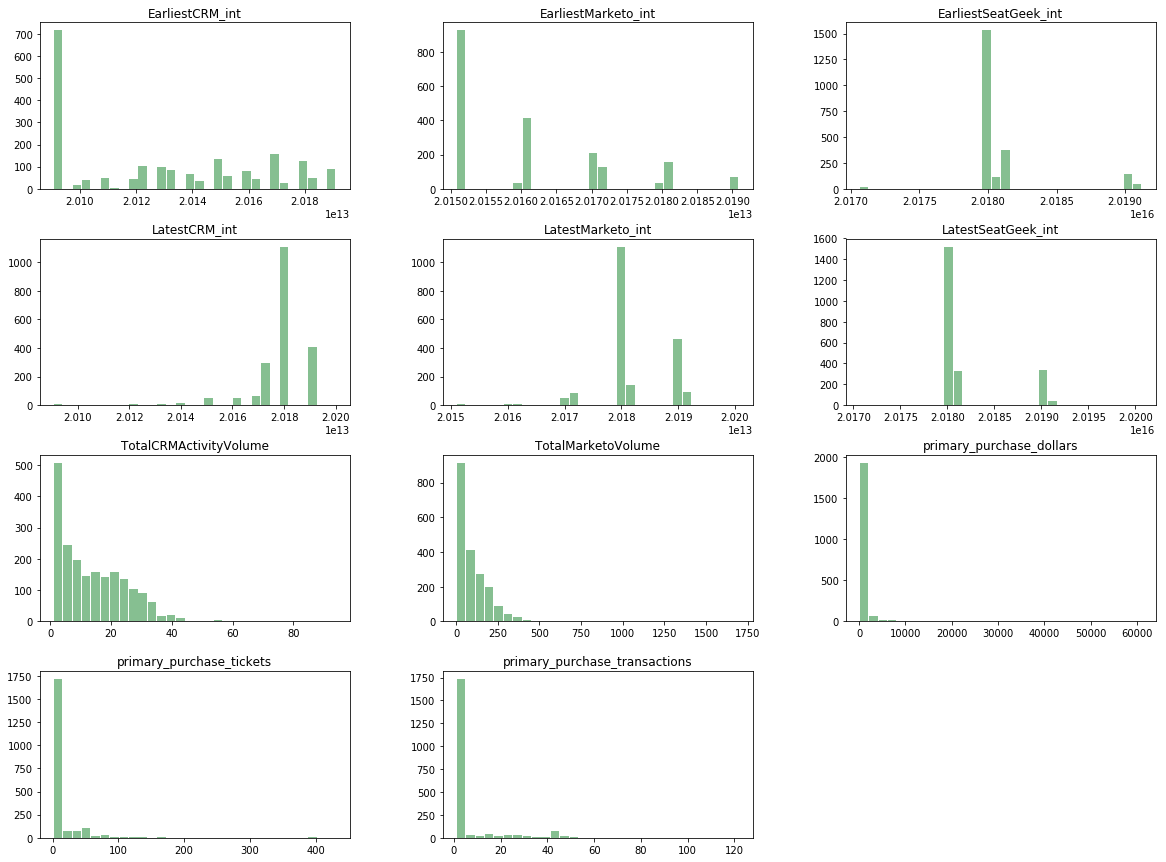

In [32]:
ax = STM.hist(bins=30, grid=False, figsize=(20,15), color='#86bf91', zorder=2, rwidth=0.9)

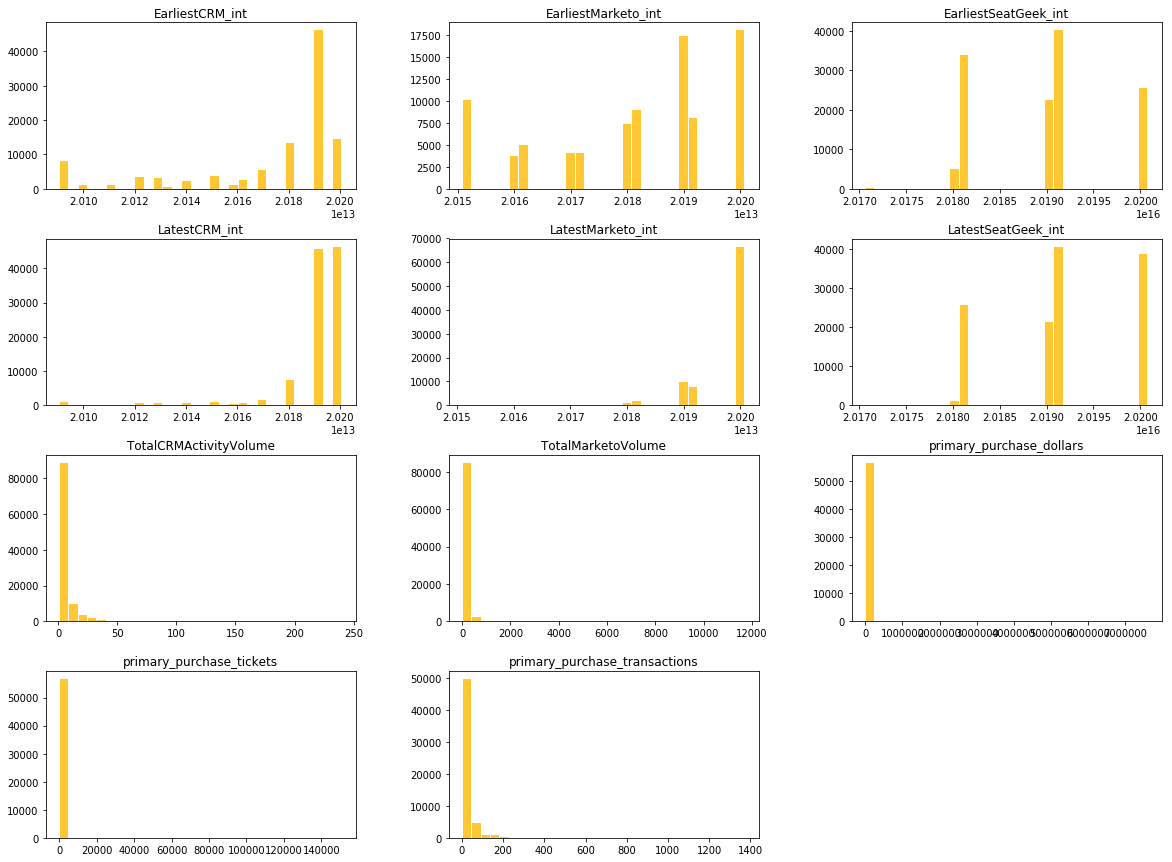

In [30]:
ax = nonSTM.hist(bins=30, grid=False, figsize=(20,15), color='#FFC733', zorder=2, rwidth=0.9)

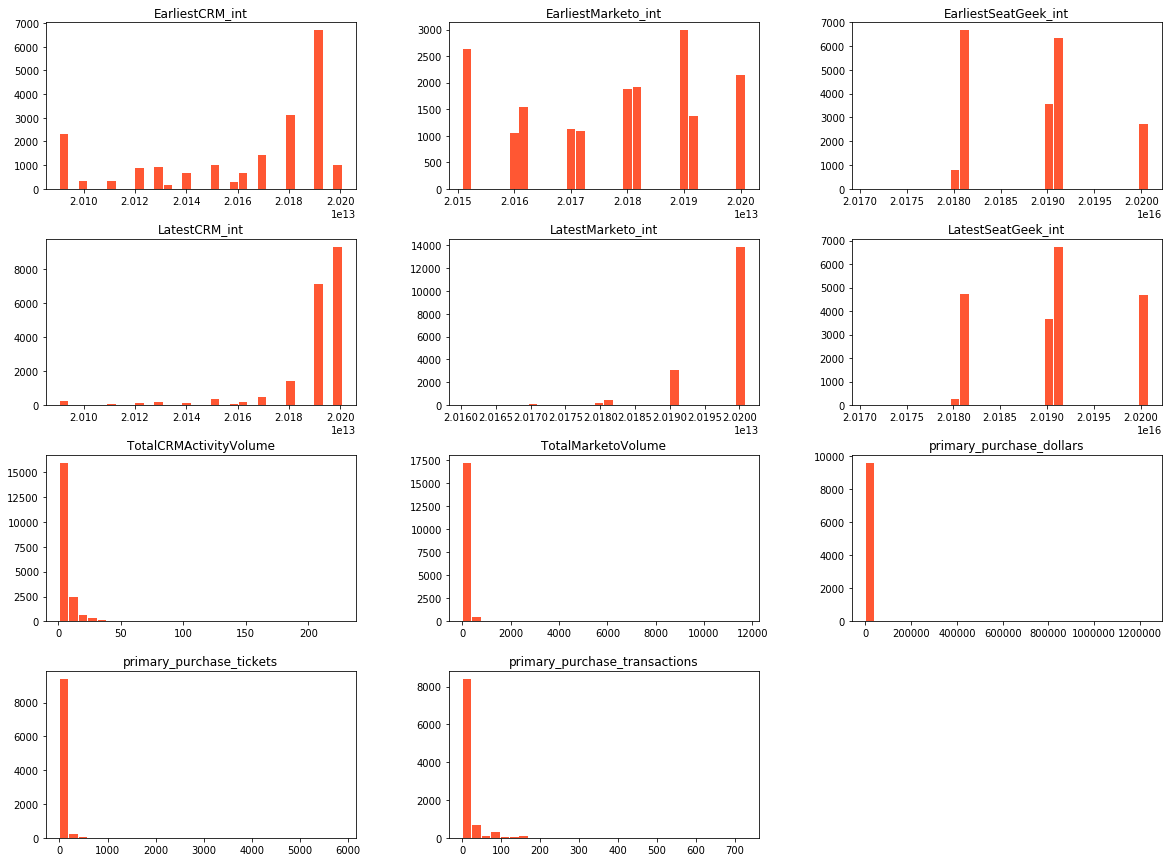

In [31]:
ax = lost.hist(bins=30, grid=False, figsize=(20,15), color='#FF5733', zorder=2, rwidth=0.9)

For n_clusters = 2 The average silhouette_score is : 0.3886496614239324
For n_clusters = 3 The average silhouette_score is : 0.38873192900583325
For n_clusters = 4 The average silhouette_score is : 0.2355183261713104
For n_clusters = 5 The average silhouette_score is : 0.24052237546232905
For n_clusters = 6 The average silhouette_score is : 0.27175134504439297
For n_clusters = 7 The average silhouette_score is : 0.2054899046862906
For n_clusters = 8 The average silhouette_score is : 0.20793855912430073
For n_clusters = 9 The average silhouette_score is : 0.20497051351553056


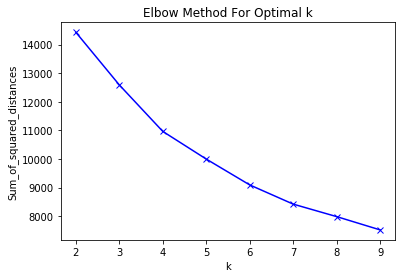

In [67]:
##STM CLUSTERING
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


df = STM.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()


scaler = StandardScaler()
scaler.fit(df)

df_standardized  = pd.DataFrame(scaler.transform(df))

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(df_standardized)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(df_standardized, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
df = STM.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()
k = 4
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(df)

train_labels = kmeans.predict(df)
df['Cluster'] = train_labels
df['Cluster'].value_counts()

0    1450
1     140
2     124
3      13
Name: Cluster, dtype: int64

In [72]:
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()

train_labels = kmeans.predict(df)
df['Cluster'] = train_labels
df['Cluster'].value_counts()

2    25835
1     9018
0     8280
3       58
Name: Cluster, dtype: int64

For n_clusters = 2 The average silhouette_score is : 0.22136965314798804
For n_clusters = 3 The average silhouette_score is : 0.22083633309829417
For n_clusters = 4 The average silhouette_score is : 0.21792217497906435
For n_clusters = 5 The average silhouette_score is : 0.2202851282972787
For n_clusters = 6 The average silhouette_score is : 0.2473961094972348
For n_clusters = 7 The average silhouette_score is : 0.23716640291322413
For n_clusters = 8 The average silhouette_score is : 0.2558941591104206
For n_clusters = 9 The average silhouette_score is : 0.2573513608657179


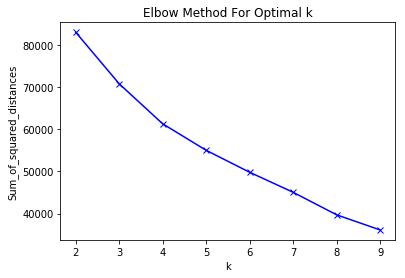

In [73]:
##LOST CLUSTERING


df = lost.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()
scaler = StandardScaler()
scaler.fit(df)

df_standardized  = pd.DataFrame(scaler.transform(df))

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(df_standardized)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(df_standardized, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [74]:
df = lost.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()
k = 4
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(df)
train_labels = kmeans.predict(df)
df['Cluster'] = train_labels
df['Cluster'].value_counts()

1    3396
2    2215
0    1636
3    1568
Name: Cluster, dtype: int64

In [63]:
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).dropna()

train_labels = kmeans.predict(df)
df['Cluster'] = train_labels
df['Cluster'].value_counts()

0    15428
2    10407
3     9018
1     8338
Name: Cluster, dtype: int64

In [64]:
STM.head()


,SSB_CRMSYSTEM_CONTACT_ID,TotalCRMActivityVolume,TotalMarketoVolume,primary_purchase_transactions,primary_purchase_dollars,primary_purchase_tickets,EarliestCRM_int,LatestCRM_int,LatestSeatGeek_int,EarliestSeatGeek_int,EarliestMarketo_int,LatestMarketo_int
0,74715C50-EF52-497B-8B9C-FF328DA164BC,20.0,99.0,1.0,0.0,2.0,2.009052e+13,2.018021e+13,2.018022e+16,2.018022e+16,2.015092e+13,2.018022e+13
1,8D3B3783-C9E1-4251-9A54-5BE78B40FDA7,2.0,80.0,52.0,7158.0,133.0,2.009052e+13,2.018012e+13,2.018100e+16,2.018020e+16,2.015092e+13,2.019052e+13
2,8D3B3783-C9E1-4251-9A54-5BE78B40FDA7,2.0,80.0,52.0,7158.0,133.0,2.009052e+13,2.018012e+13,2.018121e+16,2.018121e+16,2.015092e+13,2.019052e+13
3,8D3B3783-C9E1-4251-9A54-5BE78B40FDA7,2.0,80.0,52.0,7158.0,133.0,2.009052e+13,2.018012e+13,2.018123e+16,2.018092e+16,2.015092e+13,2.019052e+13
4,8D3B3783-C9E1-4251-9A54-5BE78B40FDA7,2.0,80.0,52.0,7158.0,133.0,2.009052e+13,2.018012e+13,2.019011e+16,2.018121e+16,2.015092e+13,2.019052e+13
